In [1]:
import main
import plot_inequality as plot_ineq
import importlib
import io_manager
import numpy as np

of_name = None
main_path = "C:/Users/Ben/My Drive/PhD/PhD Year 3/3rd Year Paper/Model/My Code/MH_Model/model_uncert/"
input_path = main_path + "input/50p_age_moms/"
trans_path_uncond = input_path + "MH_trans_uncond_age.csv"

trans_path_50p = input_path + "MH_trans_by_MH_clust_age.csv"
type_path_50p = input_path + "MH_clust_50p_age_pop_shares.csv"

do_dpi_calib = False
output_flag = False
myPars, myShocks, sols, sims = main.main_io(main_path, out_folder_name = of_name, 
                                            H_trans_uncond_path = trans_path_50p, H_type_pop_share_path = type_path_50p,
                                            output_flag = output_flag, do_dpi_calib = do_dpi_calib, do_eps_gg_calib=False)


*****Running main_io with default out_folder_name*****
Solver ran in 6.995676300000923 seconds
Calibrating with targets: 
alpha target: 0.33497447
w0_mu target: 2.1988928
w0_sigma target: 0.29847395
w1 target: 0.2928040000000003
w2 target: 0.2746706000000003
wH target: 0.051316846
phi_H target: 0.00023562394
eps_gg target: 0.39124098057692314
eps_bb target: 0.50886095
***** Calibration iteration 0 *****
Calibrating w0_mu
Calibrating w0_sigma
***** Calibration iteration 1 *****
Calibrating w0_mu
Calibrating w0_sigma
***** Calibration iteration 2 *****
Calibrating w0_mu
Calibrating w1
Calibrating w2
***** Calibration iteration 3 *****
Calibrating w1
Calibrating w2
***** Calibration iteration 4 *****
Calibrating w1
Calibrating w2
***** Calibration iteration 5 *****
Calibrating w1
Calibrating w2
***** Calibration iteration 6 *****
Calibrating w1
Calibrating w2
***** Calibration iteration 7 *****
Calibrating w1
Calibrating w2
***** Calibration iteration 8 *****
Calibrating w1
Calibrating w2

In [ ]:
from pars_shocks import Pars, Shocks
import pandas as pd
import model
import my_toolbox as tb
from numba import njit

@njit
def eps_gg_mom_giv_eps(myPars: Pars, new_eps: float)->float:
    myPars.set_eps_gg(new_eps)
    # myPars.epsilon_gg = new_eps
    myShocks = Shocks(myPars)
    return eps_gg_moment(myPars, myShocks)
@njit
def eps_gg_moment(myPars:Pars, myShocks:Shocks)->float:
    # myShocks = Shocks(myPars)
    H_hist = myShocks.H_hist
    weighted_H_hist = model.gen_weighted_sim(myPars, H_hist) 
    # the line below may prove difficult to jit
    # good_MH_age_sim = np.sum(weighted_H_hist, tuple(range(H_hist.ndim - 1)))
    good_MH_age_sim = tb.sum_last_axis_numba(weighted_H_hist)
    bad_MH_age_sim = 1 - good_MH_age_sim
    return np.mean(bad_MH_age_sim)

def get_eps_gg_targ(myPars: Pars, target_folder_path)->float:
    file_path = target_folder_path + "mean_bad_MH_by_age.csv"
    bad_MH_age_data = pd.read_csv(file_path)
    # rename the columns
    bad_MH_age_data.columns = ['age', 'mean_badMH']
    bad_MH_age_data = bad_MH_age_data['mean_badMH'].to_numpy()
    return np.mean(bad_MH_age_data)

@njit
def eps_bb_mom_giv_eps(myPars: Pars, new_eps: float)->float:
    # myPars.epsilon_bb = new_eps
    myPars.set_eps_bb(new_eps)
    myShocks = Shocks(myPars)
    return eps_bb_moment(myPars, myShocks)

target_lag = 1


@njit
def eps_bb_moment(myPars: Pars, myShocks:Shocks)-> float:
    '''
    returns the autocorrelation of health with its lag
    '''
    lag = target_lag
    H_hist = myShocks.H_hist[:, :, :, :myPars.J]
    H_hist_ac = tb.lagged_corr_jit(H_hist, max_lag=10)
    return H_hist_ac[lag]

def get_eps_bb_targ(myPars: Pars, target_folder_path: str)-> float:
    '''
    '''
    lag = target_lag
    data_moms_path = target_folder_path + '/autocorr_matrix.csv'
    autocorr_mat_pd = pd.read_csv(data_moms_path)
    MH_autocorr = autocorr_mat_pd['MH']
    return MH_autocorr.iloc[lag]

# myPars.set_eps_bb(0.0)
# print(f"old myPars.epsilon_bb = {myPars.epsilon_bb}")
# myShocks = Shocks(myPars)
# print("old moment: ", eps_bb_moment(myPars, myShocks))
# new_moment = eps_bb_mom_giv_eps(myPars, 0.03)
# print(f"new myPars.epsilon_bb = {myPars.epsilon_bb}")
# print("new moment: ", new_moment)
# print("target: ", get_eps_bb_targ(myPars, input_path))

myPars.set_eps_gg(0.0)
print(f"old myPars.epsilon_gg = {myPars.epsilon_gg}")
myShocks = Shocks(myPars)
print("old moment: ", eps_gg_moment(myPars, myShocks))
new_moment = eps_gg_mom_giv_eps(myPars, 0.03)
print(f"new myPars.epsilon_gg = {myPars.epsilon_gg}")
print("new moment: ", new_moment)
print("target: ", get_eps_gg_targ(myPars, input_path))


old myPars.epsilon_gg = 0.0
old moment:  0.44389279074357685
new myPars.epsilon_gg = 0.1
new moment:  0.3750918468050974
target:  0.39124098057692314


In [48]:
from typing import Tuple, Dict
import my_toolbox as tb
import solver
import simulate

def calib_epsilon_gg(myPars: Pars, myShocks:Shocks, main_path:str, tol:float, target:float, eps_gg_min:float, eps_gg_max:float)-> Tuple[float, float, Dict[str, np.array], Dict[str, np.array]]:
    eps_gg_moment = -999
    state_sols = {}
    sim_lc = {}

    # define the objective function
    get_eps_diff = lambda new_eps: eps_gg_mom_giv_eps(myPars,  new_eps) - target
    calibrated_eps = tb.bisection_search(get_eps_diff, eps_gg_min, eps_gg_max, tol, myPars.max_iters, myPars.print_screen)
    myPars.epsilon_gg = calibrated_eps

    # solve, simulate model for the calibrated epsilon_gg
    eps_moment = eps_gg_mom_giv_eps(myPars, calibrated_eps)
    shocks = Shocks(myPars)
    state_sols = solver.solve_lc(myPars, main_path)
    sim_lc = simulate.sim_lc(myPars, shocks, state_sols)
    if myPars.print_screen > 0:
        print(f"calibrated epsilon_gg = {calibrated_eps}, epsilon_gg moment = {eps_moment}, target = {target}")

    return calibrated_eps, eps_moment, state_sols, sim_lc

def calib_eps_bb(myPars: Pars, main_path:str, tol:float, target:float, eps_bb_min:float, eps_bb_max:float)-> Tuple[float, float, Dict[str, np.array], Dict[str, np.array]]:
    eps_bb_mom = -999.999
    state_sols = {}
    sim_lc = {}

    # define the objective function
    get_eps_diff = lambda new_eps: eps_bb_mom_giv_eps(myPars, new_eps) - target
    calibrated_eps = tb.bisection_search(get_eps_diff, eps_bb_min, eps_bb_max, tol, myPars.max_iters, myPars.print_screen)
    myPars.epsilon_bb = calibrated_eps

    # solve the model
    eps_moment = eps_bb_mom_giv_eps(myPars, calibrated_eps)
    shocks = Shocks(myPars)
    state_sols = solver.solve_lc(myPars, main_path)
    sim_lc = simulate.sim_lc(myPars, shocks, state_sols)
    if myPars.print_screen > 0:
        print(f"calibrated_eps = {calibrated_eps}, eps_moment = {eps_moment}, target = {target}")

    return calibrated_eps, eps_moment, state_sols, sim_lc

In [53]:
target = get_eps_gg_targ(myPars, input_path)
calib_gg_tuple = calib_epsilon_gg(myPars, myShocks, main_path, 1e-3, target, -0.2, 0.2)
print(calib_gg_tuple[1])
print(target)

target = get_eps_bb_targ(myPars, input_path)
calib_bb_tuple = calib_eps_bb(myPars, main_path, 1e-3, target, -0.2, 0.2)
print(calib_bb_tuple[1])
print(target)


0.3902887056941161
0.39124098057692314
0.5093055116549927
0.50886095


In [ ]:
#nested bisection search to calibrate epsilon_gg and epsilon_bb
# @njit
def calib_all_eps_numba(myPars:Pars, main_path:str,
                eps_bb_tol:float, eps_gg_tol:float, eps_bb_target:float, eps_gg_target:float,
                eps_bb_min:float = -0.3, eps_bb_max:float = 0.3, eps_gg_min:float = -0.3, eps_gg_max:float = 0.3,
                eps_bb_max_iters:int = 30, eps_gg_max_iters:int = 30, 
                )-> Tuple[float, float, float, float, Dict[str, np.array], Dict[str, np.array]]:

    eps_bb_err = lambda new_eps_bb: eps_bb_mom_giv_eps(myPars, new_eps_bb) - eps_bb_target
    eps_gg_err = lambda new_eps_gg: eps_gg_mom_giv_eps(myPars, new_eps_gg) - eps_gg_target

    # calibrate epsilon_bb
    bb_min = eps_bb_min
    bb_max = eps_bb_max
    bb_iters = 0
    bb_err = 1 + eps_bb_tol
    gg_err = 1 + eps_gg_tol
    while (abs(bb_err) > eps_bb_tol or abs(gg_err) > eps_gg_tol) and bb_iters < eps_bb_max_iters:
        # calibrate epsilon_gg 
        gg_min = eps_gg_min
        gg_max = eps_gg_max
        gg_iters = 0
        gg_err = 1 + eps_gg_tol
        while abs(gg_err) > eps_gg_tol and gg_iters < eps_gg_max_iters:
            gg_mid_pt = (gg_min + gg_max)/2
            gg_err = eps_gg_err(gg_mid_pt)
            if gg_err < 0:
                gg_max = gg_mid_pt
            else:
                gg_min = gg_mid_pt
            gg_iters += 1
            gg_err = eps_gg_err(myPars.epsilon_gg)
            print(f"gg_err: {gg_err}")
        # calibrate epsilon_bb
        bb_mid_pt = (bb_min + bb_max)/2
        bb_err = eps_bb_err(bb_mid_pt)
        if bb_err > 0:
            bb_max = bb_mid_pt
        else:
            bb_min = bb_mid_pt
        bb_iters += 1
        bb_err = eps_bb_err(myPars.epsilon_bb)
        gg_err = eps_gg_err(myPars.epsilon_gg)
        print(f"gg_err: {gg_err}, bb_err: {bb_err}")

    calib_eps_bb = myPars.epsilon_bb
    calib_eps_gg = myPars.epsilon_gg
    myShocks = Shocks(myPars)

    return myPars, myShocks, calib_eps_bb, calib_eps_gg

def calib_all_eps(myPars:Pars, main_path:str,
                eps_bb_tol:float, eps_gg_tol:float, eps_bb_target:float, eps_gg_target:float,
                eps_bb_min:float = -0.3, eps_bb_max:float = 0.3, eps_gg_min:float = -0.3, eps_gg_max:float = 0.3,
                eps_bb_max_iters:int = 5, eps_gg_max_iters:int = 5, 
                )-> Tuple[float, float, float, float, Dict[str, np.array], Dict[str, np.array]]:

    myPars, myShocks, calib_eps_bb, calib_eps_gg = calib_all_eps_numba(myPars, main_path,
                                                                       eps_bb_tol, eps_gg_tol, eps_bb_target, eps_gg_target,
                                                                       eps_bb_min, eps_bb_max, eps_gg_min, eps_gg_max,
                                                                       eps_bb_max_iters, eps_gg_max_iters)
    eps_gg_mom = eps_gg_moment(myPars, myShocks)
    eps_bb_mom = eps_bb_moment(myPars, myShocks)
    state_sols = solver.solve_lc(myPars, main_path)
    sim_lc = simulate.sim_lc(myPars, myShocks, state_sols)
    return calib_eps_bb, calib_eps_gg, eps_bb_mom, eps_gg_mom, state_sols, sim_lc

bb_target = get_eps_bb_targ(myPars, input_path)
print("bb_target = ", bb_target)
gg_target = get_eps_gg_targ(myPars, input_path)
print("gg_target = ", gg_target)
calib_eps_bb, calib_eps_gg, eps_bb_mom, eps_gg_mom, state_sols, sim_lc = calib_all_eps(myPars, main_path, 0.001, 0.001, bb_target, gg_target)
print(f"bb_err: {eps_bb_mom - bb_target}, gg_err: {eps_gg_mom - gg_target}")



bb_target =  0.50886095
gg_target =  0.39124098057692314
gg_err: 0.22890924344217833
gg_err: 0.15131379766546305
gg_err: 0.14496735773245994
gg_err: 0.14168638333086758
gg_err: 0.13960819215705478
gg_err: -0.12317254626951607, bb_err: 0.1967123472514195
gg_err: 0.03562346724606108
gg_err: -0.05946000486967251
gg_err: -0.01745449023377993
gg_err: 0.009419535102496879
gg_err: -0.004162650771783016
gg_err: 0.09808884068212065, bb_err: 0.24838283635607716
gg_err: 0.13736449198969647
gg_err: 0.04646679353625527
gg_err: 0.021680766352557057
gg_err: 0.0056094342018029875
gg_err: -0.003641551065142523
gg_err: 0.09707955208067653, bb_err: 0.45256595068265315
gg_err: 0.20145591119683748
gg_err: 0.12177021587040004
gg_err: 0.10916816593390055
gg_err: 0.10162911300396232
gg_err: 0.09707955208067653
gg_err: 0.12840823427728632, bb_err: 0.4666239311171684
gg_err: 0.22121695052388557
gg_err: 0.14352352081767472
gg_err: 0.13554084662637544
gg_err: 0.13116098194569104
gg_err: 0.12840823427728632
gg_err

   age  mean_badMH
0   25    0.482951
1   26    0.488518
2   27    0.478290
3   28    0.454662
4   29    0.460761


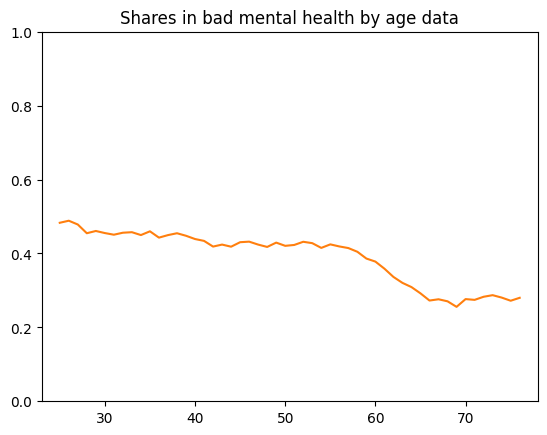

[0.48240711 0.50122985 0.52160107 0.53600245 0.54976432]


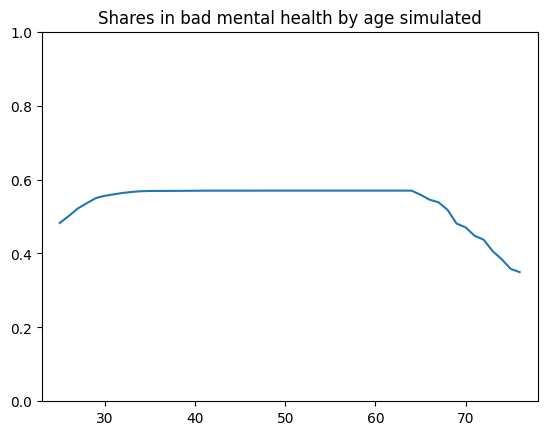

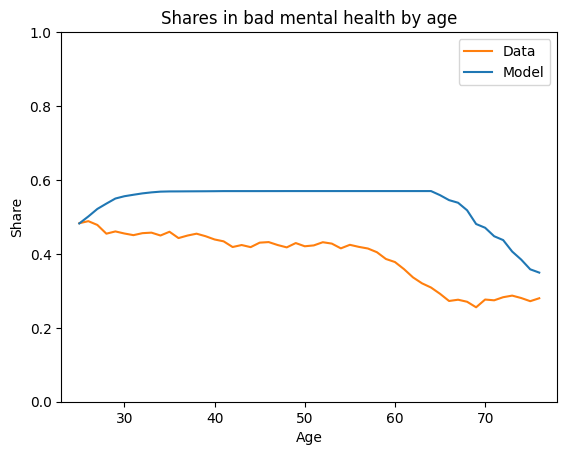

In [18]:

import model
import matplotlib.pyplot as plt
import pandas as pd
import my_toolbox as tb
import os
myShocks = Shocks(myPars)
H_hist = myShocks.H_hist

shares_y_lim = [0, 1.0]
# shares in bad health by earnings (maybe later by wage, hours, etc)
age_grid = myPars.age_grid
bad_MH_age_data = pd.read_csv(input_path + "mean_bad_MH_by_age.csv")
print(bad_MH_age_data.head())
# get second column as numpy array
bad_MH_age_data = bad_MH_age_data.to_numpy()
# plot shares in bad health by age
fig_bad_MH_data, ax_bad_MH_data = plt.subplots()
ax_bad_MH_data.plot(age_grid, bad_MH_age_data)
ax_bad_MH_data.set_title("Shares in bad mental health by age data")
ax_bad_MH_data.set_xlim([age_grid[0]-2, age_grid[-1]+2])    
ax_bad_MH_data.set_ylim(shares_y_lim)
plt.show()

# model shares in bad health by age
weighted_H_hist = model.gen_weighted_sim(myPars, H_hist) 
good_MH_age_sim = np.sum(weighted_H_hist, tuple(range(H_hist.ndim - 1)))
bad_MH_age_sim = 1 - good_MH_age_sim
print(bad_MH_age_sim[:5])
# print("good_MH_age_sim", good_MH_age_sim)
# print("bad_MH_age_sim", bad_MH_age_sim)
fig_bad_MH_sim, ax_bad_MH_sim = plt.subplots()
ax_bad_MH_sim.plot(age_grid, bad_MH_age_sim)
ax_bad_MH_sim.set_title("Shares in bad mental health by age simulated")
ax_bad_MH_sim.set_xlim([age_grid[0]-2, age_grid[-1]+2])
ax_bad_MH_sim.set_ylim(shares_y_lim)
plt.show()

label_lists = [["Data"], ["Model"]]
color_list = ["C1", "C0"]
corr_save_path = main_path + "output/H_trans_state_test/"
#if directory doesn't exist create it
if not os.path.exists(corr_save_path):
    os.makedirs(corr_save_path)
# save_path = corr_save_path + "shares_bad_MH.pdf"
save_path = None
fig_comb_bad_MH, ax_comb_bad_MH = tb.combine_plots([(fig_bad_MH_data, ax_bad_MH_data), (fig_bad_MH_sim, ax_bad_MH_sim)],
                                                    comb_fig_title = "Shares in bad mental health by age", x_label = "Age", y_label = "Share", 
                                                    label_lists = label_lists, colors= color_list, save_path = save_path)

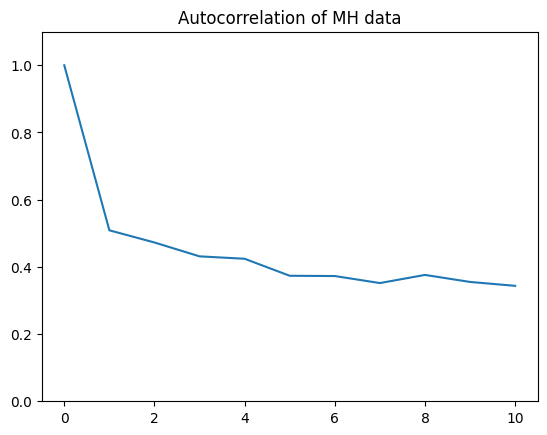

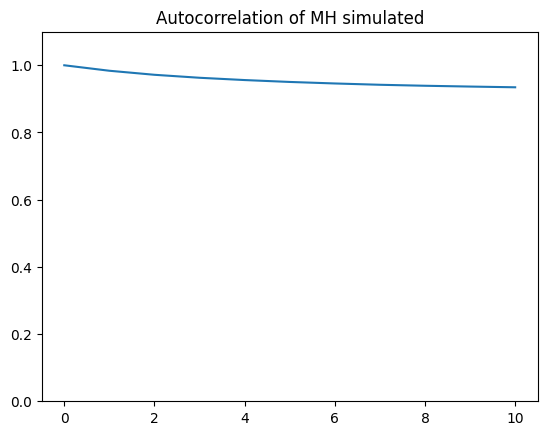

H_hist_ac [1.         0.98370872 0.97169077 0.96281562 0.95601146 0.95038738
 0.94586367 0.94197815 0.93904024 0.93666251 0.93449844]


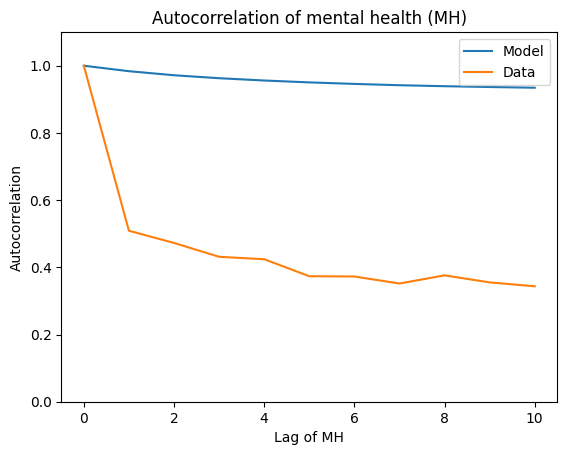

In [19]:

from typing import Tuple

def plot_autocorr(autocorr_data: np.array, var_name: str = None, y_lim: list = [0, 1.1], quietly: bool = False)-> Tuple[plt.Figure, plt.Axes]:
    fig_data, ax_data = plt.subplots()
    ax_data.plot(autocorr_data)
    ax_data.set_title(f"Autocorrelation of {var_name}")
    ax_data.set_ylim(y_lim)
    if not quietly:
        plt.show()
    return fig_data, ax_data


# Plot params
autocorr_y_lim = [0, 1.1]
# Data
autocorr_pd = pd.read_csv(input_path + "autocorr_matrix.csv")
MH_autocorr = autocorr_pd["MH"].values
fig_data_MH, ax_data_MH = plot_autocorr(MH_autocorr, "MH data", autocorr_y_lim, quietly = False)

# Model
H_hist = myShocks.H_hist[:, :, :, :-1]
H_hist_ac = tb.lagged_corr(H_hist, max_lag=10)
fig_sim_H_ac, ax_sim_H_ac = plot_autocorr(H_hist_ac, "MH simulated", autocorr_y_lim)
print("H_hist_ac", H_hist_ac)

# Combine
comb_fig_title_prefix = "Autocorrelation of "
label_lists = [["Model"], ["Data"]]
color_list = ["C0", "C1"]
x_label = "Lag"
y_label = "Autocorrelation"
# save_path =corr_save_path + "autocorr_MH.pdf"
save_path = None
fig_comb_MH_autocorr, ax_comb_MH_autocorr = tb.combine_plots([(fig_sim_H_ac, ax_sim_H_ac), (fig_data_MH, ax_data_MH)],
                                                                comb_fig_title = comb_fig_title_prefix + "mental health (MH)",  
                                                                x_label = x_label + " of MH", y_label = y_label,
                                                                label_lists = label_lists, colors= color_list, save_path = save_path)